### Import Packages

In [174]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn import model_selection, preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
import sklearn.metrics as sklm

import xgboost as xgb
color = sns.color_palette()


from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from subprocess import check_output


%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [175]:
#Reduce VIF 

from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

### Import data

In [176]:

# change wd and import data files
os.chdir("/Users/hubertjenq/kaggle/sberbank russian housing")
train_df = pd.read_csv("train.csv",parse_dates=['timestamp'])
test_df = pd.read_csv("test.csv",parse_dates=['timestamp'])
VIFvalues=pd.read_csv("VIFvalues.csv")

#use only macroeconomic columns from the macro data
macroecon_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]



macro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macroecon_cols)

In [177]:
train_df.columns.values

array(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq', 'state',
       'product_type', 'sub_area', 'area_m', 'raion_popul',
       'green_zone_part', 'indust_part', 'children_preschool',
       'preschool_quota', 'preschool_education_centers_raion',
       'children_school', 'school_quota', 'school_education_centers_raion',
       'school_education_centers_top_20_raion', 'hospital_beds_raion',
       'healthcare_centers_raion', 'university_top_20_raion',
       'sport_objects_raion', 'additional_education_raion',
       'culture_objects_top_25', 'culture_objects_top_25_raion',
       'shopping_centers_raion', 'office_raion',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion',
       'detention_facility_raion', 'full_all', 'male_f', 'female_f',
       'young_all', 'young_male', 'young

## Data Quality/error fixes

### Fixes for training data

In [178]:
#drop the samples with price>100,000,000$

price_ulimit = 1E8
train_df.loc[train_df['price_doc'] < price_ulimit] 
train_df =  train_df.loc[train_df['price_doc'] < price_ulimit] 

#fix wrong state to the most occured state
train_df.loc[train_df['state'] == 33, 'state'] = train_df['state'].mode().iloc[0]

#fix build year errors
train_df[train_df['build_year']==0]['build_year']=np.nan
train_df[train_df['build_year']==1]['build_year']=np.nan
train_df[train_df['build_year']==3]['build_year']=np.nan
train_df[train_df['build_year']==4965]['build_year']=np.nan
train_df[train_df['build_year']==71]['build_year']=np.nan

In [179]:
train_df['build_year']=train_df['build_year'].replace(215,2015)
train_df['build_year']=train_df['build_year'].replace(20052009,2005)
train_df['build_year']=train_df['build_year'].replace(20,2000)

### resample the investment 

In [180]:

sub_df = train_df[train_df.timestamp < '2015-01-01']
sub_df = sub_df[sub_df.product_type.values == 'Investment']

ind_1m = sub_df[sub_df.price_doc <= 1000000].index
ind_2m = sub_df[sub_df.price_doc == 2000000].index
ind_3m = sub_df[sub_df.price_doc == 3000000].index

train_index = set(train_df.index.copy())

for ind, gap in zip([ind_1m, ind_2m, ind_3m], [10, 3, 2]):
    ind_set = set(ind)
    ind_set_cut = ind.difference(set(ind[::gap]))

    train_index = train_index.difference(ind_set_cut)

train_df = train_df.loc[train_index, :]


### Merge train/test for more cleaning/feature generation

In [181]:

#Make a data frame with all the data in it

#count test/train data
num_train=train_df.shape[0]
num_test=train_df.shape[0]

#save id and price of the train/test 
train_id=train_df['id']
train_logprice=np.log1p(train_df['price_doc'].values)
test_id=test_df['id']

#drop id and price
train_df.drop(['id','price_doc'],axis=1,inplace=True)
test_df.drop(['id'],axis=1,inplace=True)

#Combine test/train and the macro data by timestamp
all_df = pd.concat([train_df,test_df])
all_df = pd.merge_ordered(all_df,macro_df,on='timestamp',how='left')
all_df.head()


,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

### All data error fixes

In [182]:
#remove extreme life/full square footage values and set as NA

full_sq_ulimit = 250
life_sq_ulimit = 250
full_sq_llimit = 10
life_sq_llimit = 5
all_df.loc[all_df['full_sq']>full_sq_ulimit, 'full_sq'] = np.nan
all_df.loc[all_df['full_sq']<full_sq_llimit, 'full_sq'] = np.nan
all_df.loc[all_df['life_sq']>life_sq_ulimit, 'life_sq'] = np.nan
all_df.loc[all_df['life_sq']<life_sq_llimit, 'life_sq'] = np.nan

#living square footage is probably incorrect if it is over 90% of total square footage, so set to NA
all_df['life_full_ratio'] = all_df['life_sq'] / all_df['full_sq']
all_df.loc[all_df['life_full_ratio'] > 0.9, 'life_sq'] = np.nan

#Set max/floor floor values of 0 to nan
all_df.loc[all_df['floor'] == 0, 'floor'] = np.nan
all_df.loc[all_df['max_floor'] == 0, 'max_floor'] = np.nan

#Set the max/floor values to nan if the floor is higher than the "max floor"
all_df.loc[all_df['max_floor'] < all_df['floor'], ['floor', 'max_floor']] = np.nan
#remove buildings built in the future/very old buildings
all_df.loc[all_df['build_year'] > 2017, 'build_year'] = np.nan
all_df.loc[all_df['build_year'] < 1900, 'build_year'] = np.nan

#remove num room for extremes
all_df.loc[all_df['num_room'] == 0, 'num_room'] = np.nan
all_df.loc[all_df['num_room'] >= 10, 'num_room'] = np.nan

#set smaller than 3 kitchen_sq's to not footage
all_df.loc[all_df['kitch_sq'] <= 3.0 , 'kitch_sq'] = np.nan

#if the house is a high percentage kitchen, set the kitchen to na
all_df.loc[all_df['full_sq'] - all_df['kitch_sq'] <= 5.0 , 'kitch_sq'] = np.nan

#state typo
all_df.loc[all_df['state'] == 33 , 'state'] = 3

### Make new features

In [183]:
#Convert timestamp to year, month, day of week, and date 
all_df['yearsale']=pd.DatetimeIndex(all_df['timestamp']).year
all_df['monthsale']=pd.DatetimeIndex(all_df['timestamp']).month
all_df['dayofweeksale']=pd.DatetimeIndex(all_df['timestamp']).weekday
all_df['dateofsale']=pd.DatetimeIndex(all_df['timestamp']).day


In [184]:
#add houseage
all_df['houseage']=2020-all_df['build_year']

In [185]:
#add number of floors from top
all_df['floorsfromtop']=all_df['max_floor']-all_df['floor'].astype(float)
#relative floors
all_df['relativefloor']=all_df['floor']/all_df['max_floor'].astype(float)
#add average room size
all_df['avgroomsize']=all_df['full_sq']/all_df['num_room'].astype(float)
#add kitchen size percentage of house
all_df['kitchenpercentage']=all_df['kitch_sq']/all_df['full_sq'].astype(float)

#drop timestamp
all_df.drop(['timestamp'],inplace=True,axis=1)

#Drop high VIF
#drop covariates based on VIF:
highVIF = VIFvalues.covariate.values[:50]
all_df.drop(highVIF,inplace=True,axis=1)

In [186]:
all_obj_df=all_df.select_dtypes(include=['object']).copy()
all_num_df=all_df.select_dtypes(exclude=['object'])
#XforVIF=all_num_df.copy()[:num_train]

##CHANGE HERE
#all_num_df=ReducedX

#Change catagorical variables to factors

for o in all_obj_df:
    all_obj_df[o] = pd.factorize(all_obj_df[o])[0]

#put categorical and numeric variables back together
all_df_values=pd.concat([all_num_df,all_obj_df],axis=1)

#convert to numeric values
all_x = all_df_values.values

colnames=all_df_values.columns.values


In [187]:
#split all data back into test/training

train_x = all_x[:num_train]
test_x = all_x[num_train:]

#choose 7626 training and 30507 test
indices = np.random.permutation(train_x.shape[0])
valind = indices[:round(.2*train_x.shape[0])]
trainind = indices[round(.2*train_x.shape[0]):]

val_x = train_x[valind]
trainmod_x = train_x[trainind]
val_y = train_logprice[valind]
trainmod_y = train_logprice[trainind]



In [188]:
#transformer = ReduceVIF()
# Only use 10 columns for speed in this example
#ReducedX = transformer.fit_transform(XforVIF[XforVIF.columns[:]], val_y)

#ReducedX.head()


#ReducedX.to_csv('VIFx.csv', index=False)

In [189]:
#Convert the data to xgb matrices

xgbfulltrain=xgb.DMatrix(train_x,train_logprice,feature_names=colnames)
xgbtrain=xgb.DMatrix(trainmod_x,trainmod_y,feature_names=colnames)
xgbval=xgb.DMatrix(val_x,val_y,feature_names=colnames)
xgbtest=xgb.DMatrix(test_x,feature_names=colnames)

# Find optimal number of boosting Rounds

In [190]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

partial_model = xgb.train(xgb_params, xgbtrain, num_boost_round=1000, evals=[(xgbval, 'eval')],early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	eval-rmse:14.4313
Will train until eval-rmse hasn't improved in 20 rounds.
[20]	eval-rmse:5.18708
[40]	eval-rmse:1.88862
[60]	eval-rmse:0.747174
[80]	eval-rmse:0.408955
[100]	eval-rmse:0.339418
[120]	eval-rmse:0.327563
[140]	eval-rmse:0.324753
[160]	eval-rmse:0.323553
[180]	eval-rmse:0.322752
[200]	eval-rmse:0.322422
[220]	eval-rmse:0.322017
[240]	eval-rmse:0.321807
[260]	eval-rmse:0.321744
[280]	eval-rmse:0.321682
[300]	eval-rmse:0.321688
Stopping. Best iteration:
[280]	eval-rmse:0.321682



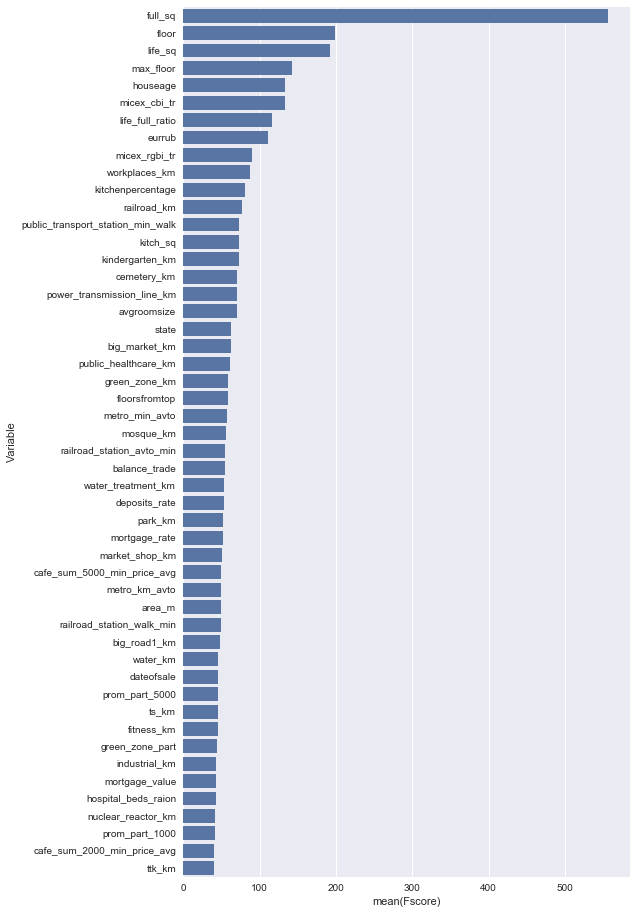

In [191]:
importance = partial_model.get_fscore()
VariableImpDf=pd.DataFrame(list(importance.items()),columns=['Variable','Fscore'])
SortedVIDf=VariableImpDf.sort_values('Fscore',ascending=False)
fig=plt.figure(figsize=(8,16))
sns.barplot(SortedVIDf.Fscore[0:50],SortedVIDf.Variable[0:50],color=color[0])

In [192]:
model = xgb.train(dict(xgb_params, silent=0), xgbfulltrain , num_boost_round=num_boost_round)

In [193]:
ylog_pred = model.predict(xgbtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)


# Hyperparameter optimization

In [ ]:
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000,1),
             'max_depth': 5,
             'eta' : hp.uniform('eta', 0.001, 0.5),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 7,1),
             'subsample' : hp.quniform('subsample', 0.5, 1,.05),
             'gamma' : hp.quniform('gamma', 0.05, 1,0.025),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.025),
             'objective': 'reg:linear',
             'eval_metric': 'rmse',
             'silent' : 0,
             'lambda' : hp.quniform('lambda',0,1,.015),
             'alpha' : hp.quniform('alpha',0,1,.015)
             }



In [ ]:
def score(params):
    boost_rounds=int(params['n_estimators'])
    model = xgb.train(params, xgbtrain, num_boost_round=boost_rounds)
    del params['n_estimators']
    
    predictions = model.predict(xgbval)
    yval=xgbval.get_label()
    score = np.sqrt(sklm.mean_squared_error(yval, predictions))
    print("\tObjective {0}\n\n".format(score))
    
    return {'loss': score, 'status': STATUS_OK}

In [ ]:
trials = Trials()

In [ ]:
trials = Trials()
best = fmin(fn=score, space=space, algo=tpe.suggest, trials=trials, max_evals=2000)

In [ ]:
model = xgb.train(best, xgbfulltrain, num_boost_round=int(best['n_estimators']))
np.sqrt(sklm.mean_squared_error(yval, model.predict(xgbval)))

In [ ]:
best

In [ ]:
model.attributes()

In [ ]:
best={'alpha': 0.615,
   'colsample_bytree': 0.525,
   'eta': 0.012712929939504953,
   'gamma': 0.9750000000000001,
   'lambda': 0.6749999999999999,
   'min_child_weight': 7.0,
   'n_estimators': 979,
   'subsample': 0.8500000000000001}

In [ ]:
values=[trials.results[x]['loss'] for x in range(0,len(trials.results))]

In [ ]:
values=[]
for x in range(0,(984)):
    values.append(trials.results[x]['loss'])

In [ ]:

trials.trials[values.index(min(values))]

In [ ]:
ylog_pred = model.predict(xgbtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)
